# LibCBM versus CBM-CFS3 growth testing #
This notebook is a automated test of the growth curve implementation in CBM-CFS3 versus that in LibCBM.  The objective is to ensure that LibCBM results match the established CBM-CFS3 model very closely. 

The script automatically generates randomized merchantable volume growth curves in various configurations
 * a random number of merchantable volume curve components, which can result in purely softwood, purely hardwood or mixed stands
 * random spatial unit (which is associated with biomass conversion parameters)
 * one of several random age/volume curve generators with varying amplitudes and start points (impulse, ramp, step, and exp curve)
 
It then compares the results and sorts them by largest different for plotting.

In [16]:
import os, json, math
import numpy as np
import pandas as pd
%matplotlib inline


In [17]:
from libcbm.test import casegeneration
from libcbm.test.cbm3support import cbm3_simulator
from libcbm.test import simulator
from libcbm.test import poolcomparison


variables and paths needed to run the tests

In [18]:
age_interval=5
num_age_classes = 40 #required by cbm3
n_steps = 250
cbm3_exe_path = r"D:\CODE\work_related\LibCBM\cbm-cfs3\20190530_growth_increment_fix"
toolbox_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3"
archive_index_db_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Admin\DBs\ArchiveIndex_Beta_Install.mdb"

cbm_defaults_db_path = 'D:\CODE\work_related\cbm_defaults\cbm_defaults.db'
libcbm_path = r'D:\CODE\work_related\LibCBM\LibCBM_Build\build\LibCBM\Release\LibCBM.dll'

generate randomized growth curve test cases

In [19]:
cases = casegeneration.generate_scenarios(
    random_seed = 2,
    num_cases = 500,
    dbpath = cbm_defaults_db_path,
    n_steps=n_steps,
    max_disturbances = 0,
    max_components = 1,
    growth_generator = lambda: casegeneration.choose_random_yield_func,
    n_growth_digits = 2,
    age_interval=age_interval,
    growth_curve_len=age_interval*num_age_classes,
    growth_only=True)


run the test cases on libCBM

In [20]:
libcbm_result = simulator.run_libCBM(libcbm_path, cbm_defaults_db_path, cases, n_steps)

run test cases on cbm-cfs3. uses [StandardImportToolPlugin](https://github.com/cat-cfs/StandardImportToolPlugin) and [cbm3-python](https://github.com/cat-cfs/cbm3_python) to automate cbm-cfs3 functionality

In [21]:
project_path = cbm3_simulator.import_cbm3_project(
    name="growth_curve_testing",
    cases=cases,
    age_interval=age_interval,
    num_age_classes=num_age_classes,
    nsteps=n_steps,
    cbm_exe_path=cbm3_exe_path,
    toolbox_path=toolbox_path,
    archive_index_db_path=archive_index_db_path)

cbm3_results_path = cbm3_simulator.run_cbm3(
    aidb_path=archive_index_db_path, 
    project_path=project_path,
    toolbox_path=toolbox_path,
    cbm_exe_path=cbm3_exe_path)

cbm3_result = cbm3_simulator.get_cbm3_results(cbm3_results_path)

join the results for plotting

In [22]:
pools_merged, pool_diffs = poolcomparison.join_pools(libcbm_result["pools"], cbm3_result["pools"], "biomass")

plot the worst 20 differences

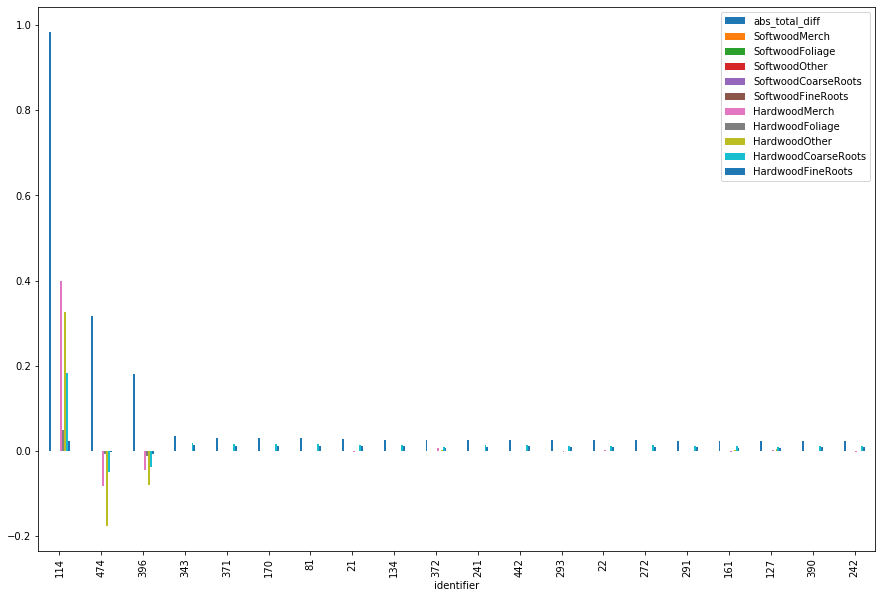

In [24]:
pool_diffs_totals = pool_diffs.drop(columns="timestep")
pool_diffs_totals \
    .groupby("identifier").sum() \
    .sort_values("abs_total_diff", ascending=False) \
    .head(20) \
    .plot(figsize=(15,10), kind="bar")

In [9]:
def plot_diff(id):
    markers = ["o","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","+","x","X","D","d"]
    bio_pools = pools_merged[pools_merged["identifier"]==casegeneration.get_classifier_name(id)]
    bio_pools = bio_pools.drop(columns="identifier")
    bio_pools = bio_pools.groupby("timestep").sum()
    ax = bio_pools.plot(figsize=(15,12), title=casegeneration.get_classifier_name(id))
    for i, line in enumerate(ax.get_lines()):
        line.set_marker(markers[i%len(markers)])
    ax.legend(ax.get_lines(), bio_pools.columns, loc='best')
    bio_diffs = pool_diffs[pool_diffs["identifier"]==casegeneration.get_classifier_name(id)]
    bio_diffs.drop(columns="identifier")
    bio_diffs.groupby("timestep").sum() \
        .plot(figsize=(15,12), title=casegeneration.get_classifier_name(id))

plot a few of the worst cases for debugging

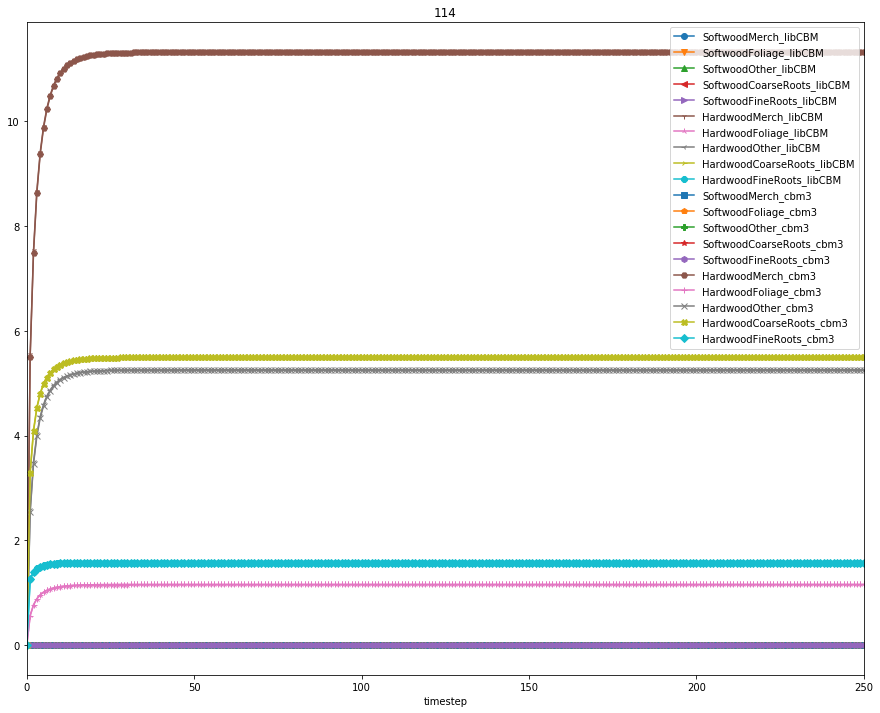

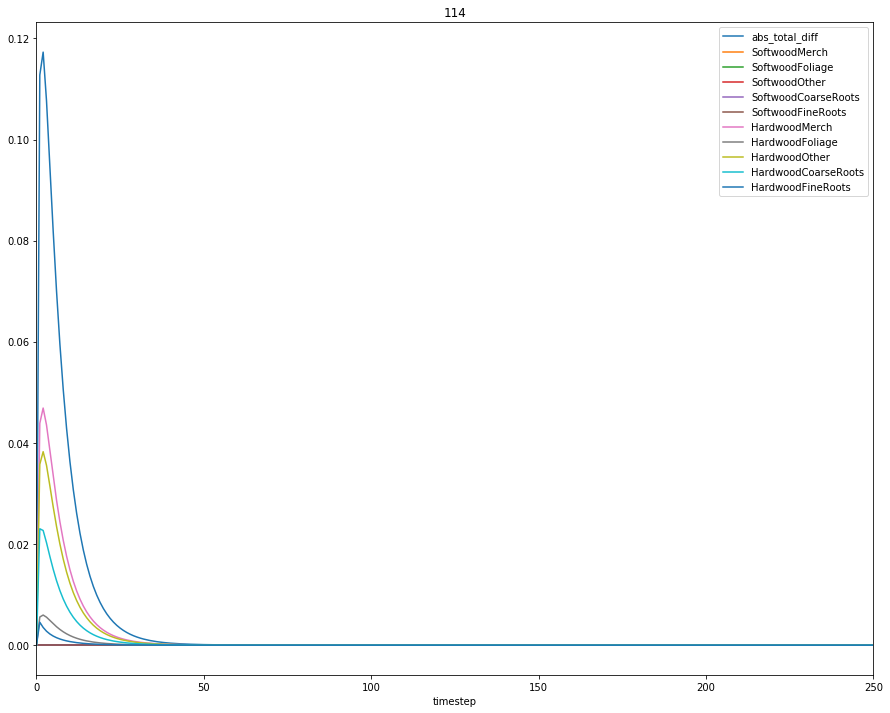

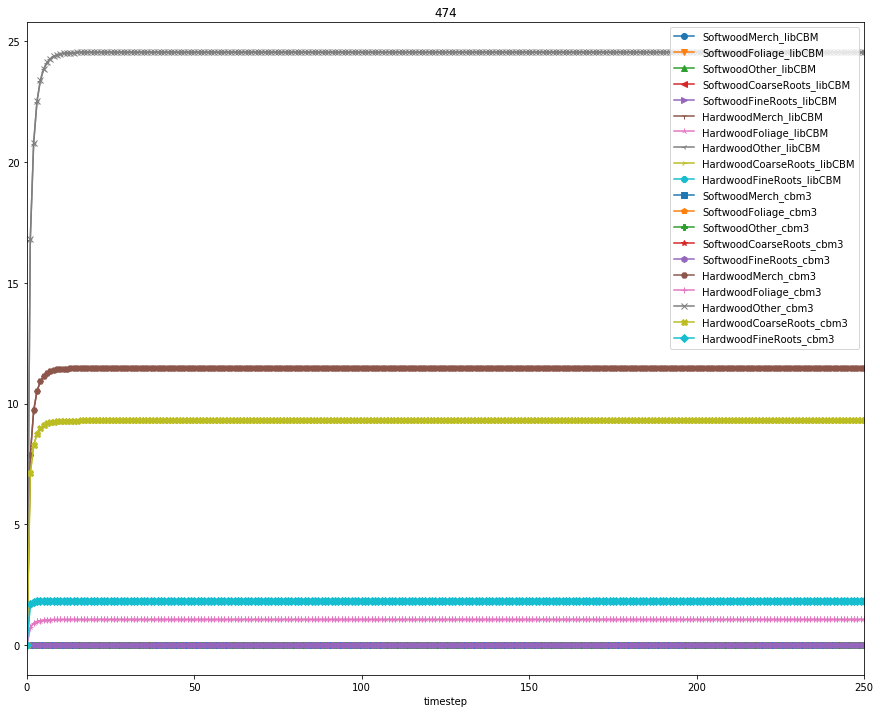

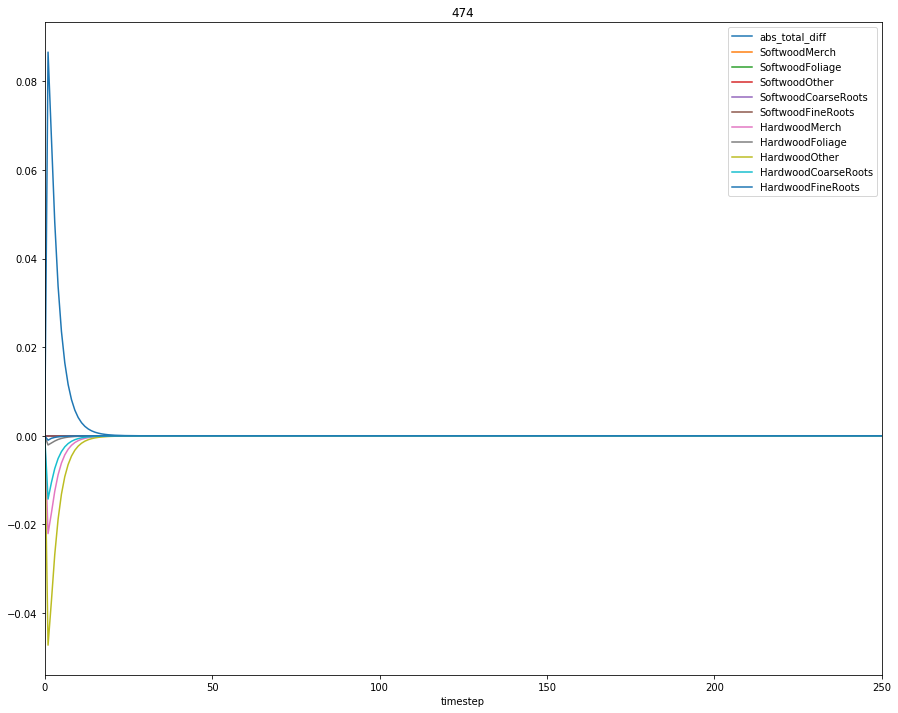

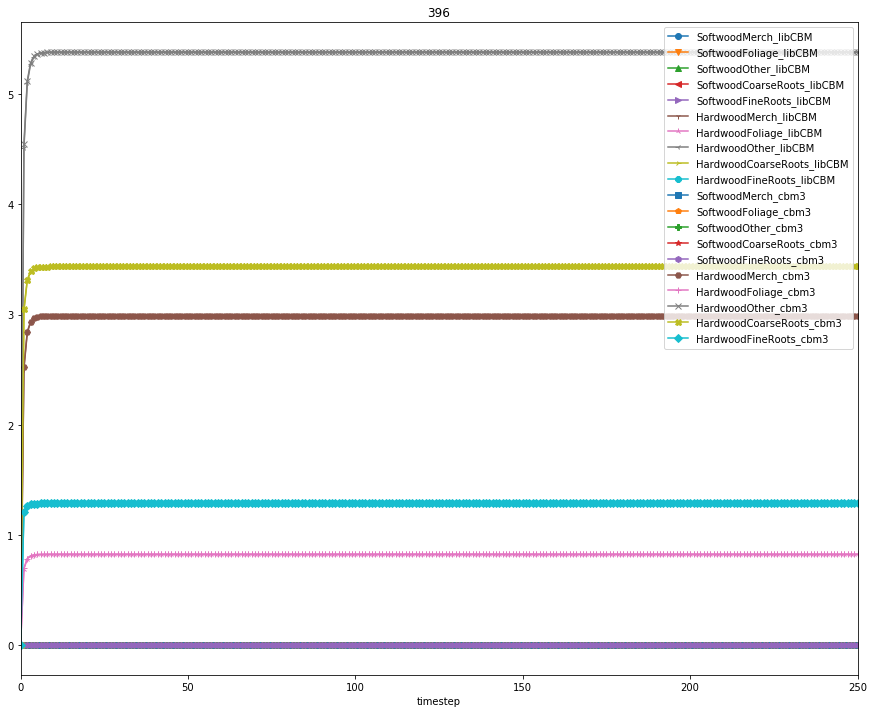

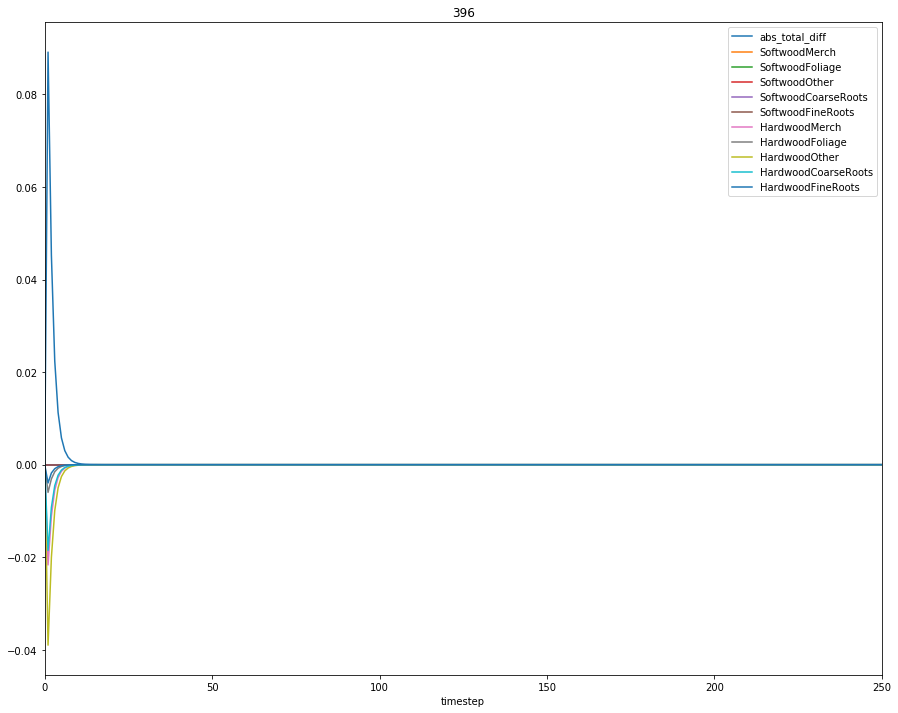

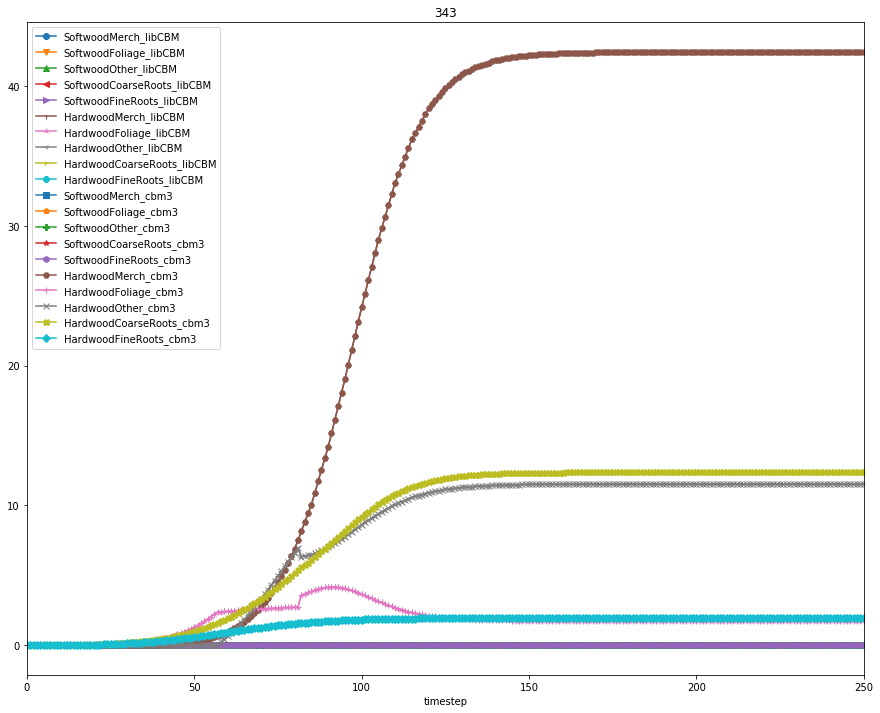

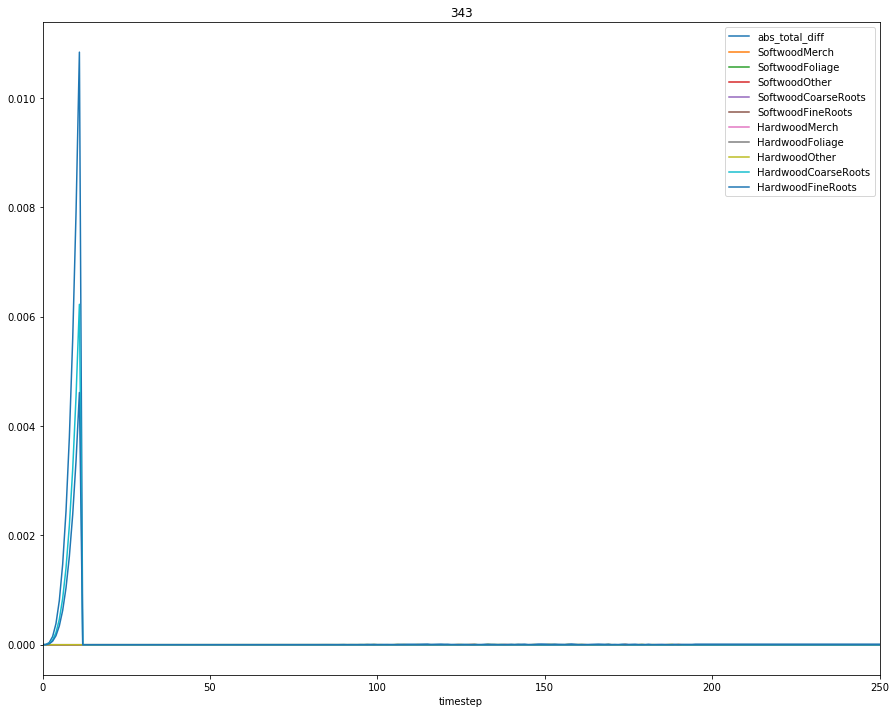

In [27]:
plot_diff(114)
plot_diff(474)
plot_diff(396)
plot_diff(343)